In [2]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import random
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
from pyqubo import Spin
import neal
import time
import numpy as np
import pandas as pd

### Ploting Chimera topology

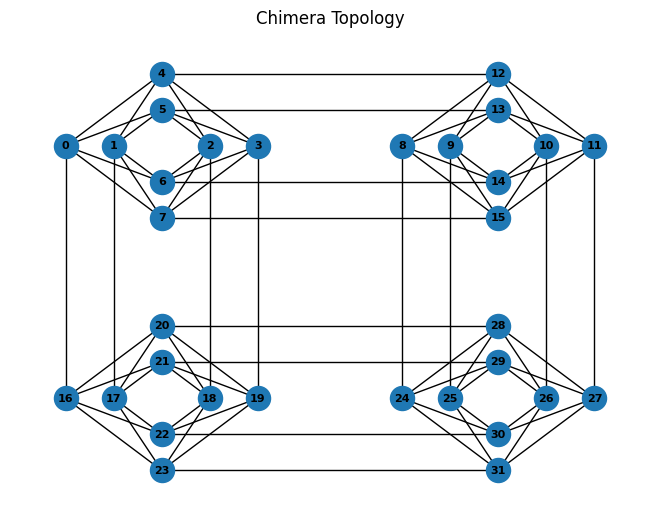

In [3]:
# Set the size of the Chimera lattice
rows, columns = 2, 2  # Adjust the values based on the size of the lattice you want to visualize

# Create the Chimera graph
chimera_graph = dnx.chimera_graph(rows, columns)

# Visualize the graph
pos = dnx.chimera_layout(chimera_graph)
nx.draw(chimera_graph, pos, with_labels=True, node_size=300, font_size=8, font_color='black', font_weight='bold')
plt.title('Chimera Topology')
plt.show()

### Ploting Pegasus topology

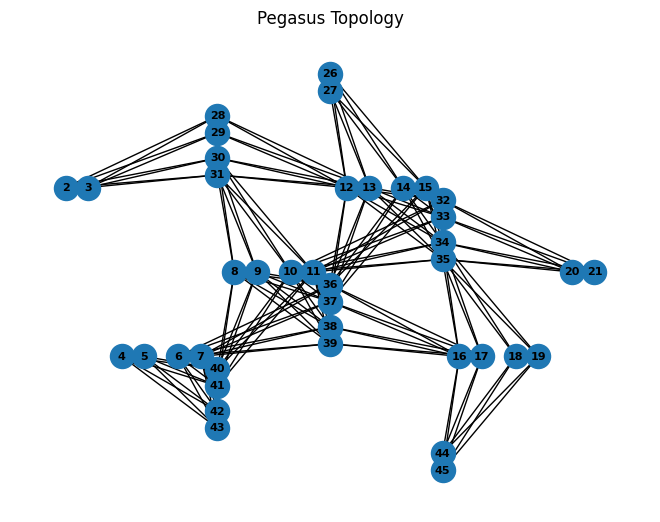

In [4]:
# Set the size of the Pegasus lattice
L = 2  # Adjust the value based on the size of the lattice you want to visualize

# Create the Pegasus graph
pegasus_graph = dnx.pegasus_graph(L)

# Visualize the graph
pos = dnx.pegasus_layout(pegasus_graph)
nx.draw(pegasus_graph, pos, with_labels=True, node_size=300, font_size=8, font_color='black', font_weight='bold')
plt.title('Pegasus Topology')
plt.show()

### Selecting some qubits of the graph

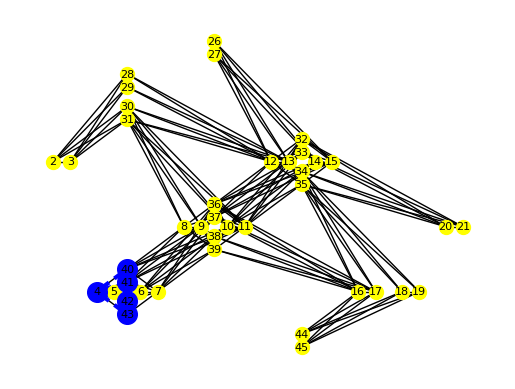

In [5]:
G = dnx.pegasus_graph(2)
H = dnx.pegasus_graph(2, node_list=[4, 40, 41, 42, 43],
              edge_list=[(4, 40), (4, 41), (4, 42), (4, 43)])
# Show graph H on a small Pegasus lattice
f, axes = plt.subplots(1, 1)
dnx.draw_pegasus(G, with_labels=True, crosses=True, font_size=8, node_size=100, node_color="Yellow", ax=axes)
dnx.draw_pegasus(H, crosses=True, font_size=8, node_size=200, node_color='b', style='dashed', edge_color='b', width=3, ax=axes)
plt.show()

##### Here we get a problem. The nodes identifier from the dnx.pegasus_graph() are not the same as in the D'Wave architecture. Moreover, there is no trivial way to graph
##### the dnx.pegasus_graph() to the architecture (to copy the embedding).
##### Because of that, we will get the qubits and couplers we want to use directly from the architecture, in order to have a direct embedding one to one (logical-physical qubit)

### From a selected qubits of the architecture, generate random values h and J and solve it with QPU and ExactSolver

In [6]:
def ising_and_embedding(a, b):
    #List of all the qubits and couples of Advantage_system4.1 (Pegasus)
    couplers_indices = DWaveSampler().edgelist
    qubit_indices = DWaveSampler().nodelist
    
    #We start only for qubits 30-50
    couplers=[]
    qubits=[]
    for couple in couplers_indices:
        if a <= couple[0] <= b:
            couplers.append(couple)
            if couple[0] not in qubits:
                qubits.append(couple[0])
            if couple[1] not in qubits:
                qubits.append(couple[1])
    
    
    #Define embedding
    embedding = {q: [q] for q in qubits} #Because the nodelist and the edgelist are from the architecture, we can assign each node/variable to a qubit on the embedding
    
    #Generate random values of h and J
    h = {qubit: random.uniform(-2, 2) for qubit in qubits}
    J = {(c[0], c[1]): random.uniform(-1,1) for c in couplers}

    return h, J, embedding

#### Small problem

##### Solving with D'Wave QPU

In [7]:
h, J, embedding = ising_and_embedding(30,35) #The values are the range of the "central" qubits we get (from each of these qubits we will also get its neighbours).
                                             #It is important to know that the first qubit in the architecture is the number 30

num_reads=100
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    sampler = FixedEmbeddingComposite(DWaveSampler(token='DEV-291d80af600d6eb433a8019c579070ba37436e9a'), embedding=embedding)
    sample_set_small = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_small)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
   30 31 32 33 34 35 36 45 46 47 48 49 50 2940 ... 3885     energy num_oc. ...
0  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1 -42.001177      36 ...
1  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1 -41.961661      23 ...
2  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1  -41.86522       7 ...
3  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1 -41.825705       3 ...
4  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1   -1 ...   -1 -41.671702       5 ...
5  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1   -1 ...   -1 -41.632187       3 ...
6  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1   -1 ...   -1 -41.535745       3 ...
7  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1  -41.50266       2 ...
8  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1   -1 ...   -1  -41.49623       3 ...
9  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1 -41.463145       2 ...
10 -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1 ...   -1 -41.382793       3 ...
11 -1 -1 -1 -1 -1 -1 +1 -1 -1 +

In [8]:
dwave.inspector.show(sample_set_small)

Serving Inspector on http://127.0.0.1:18000/?problemId=ffd46692-0100-4aa8-9c72-f3d1c87a4c8a

'http://127.0.0.1:18000/?problemId=ffd46692-0100-4aa8-9c72-f3d1c87a4c8a'

##### Solving with Simulated Annealing

In [9]:
ising_model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.Vartype.SPIN)
sampler = neal.SimulatedAnnealingSampler()
start_time = time.time()
response_small = sampler.sample(ising_model, num_reads=100)
end_time = time.time()

print("Using SimulatedAnnlearingSampler()... Time:", round(end_time-start_time, 2), "s.")
print(response_small)

Using SimulatedAnnlearingSampler()... Time: 0.06 s.
   30 31 32 33 34 35 36 45 46 47 48 49 50 2940 2955 ... 3885     energy num_oc.
0  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
1  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
2  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
3  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
4  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
5  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
6  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
7  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
8  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
9  -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001177       1
10 -1 -1 -1 -1 -1 -1 +1 -1 -1 +1 -1 +1 +1   -1   -1 ...   -1 -42.001

#### Small problem in the middle of the architecture

##### Solving with D'Wave QPU

In [10]:
h, J, embedding = ising_and_embedding(300,330) #The values are the range of the "central" qubits we get (from each of these qubits we will also get its neighbours).
                                             #It is important to know that the first qubit in the architecture is the number 30

num_reads=100
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    sampler = FixedEmbeddingComposite(DWaveSampler(token='DEV-291d80af600d6eb433a8019c579070ba37436e9a'), embedding=embedding)
    sample_set_small_middle = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_small_middle)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
   300 301 302 303 304 305 306 307 308 309 310 ... 5656      energy num_oc. ...
0   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -261.222401       1 ...
1   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -261.171525       1 ...
2   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -261.121294       1 ...
3   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1  -261.04916       1 ...
4   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.969564       1 ...
5   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.937756       1 ...
6   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.914922       1 ...
7   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.882237       1 ...
8   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1  -260.83342       1 ...
9   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.824149       1 ...
10  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1 ...   -1 -260.702887       1 ...
11  -1  +1  -1  +1 

In [11]:
print(len(h))
dwave.inspector.show(sample_set_small_middle)

217


Serving Inspector on http://127.0.0.1:18000/?problemId=89e696c1-0be5-473c-962b-4453118fb01b

'http://127.0.0.1:18000/?problemId=89e696c1-0be5-473c-962b-4453118fb01b'

##### Solving with simmulated annealing

In [12]:
ising_model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.Vartype.SPIN)
sampler = neal.SimulatedAnnealingSampler()
start_time = time.time()
response_small_middle = sampler.sample(ising_model, num_reads=100)
end_time = time.time()

print("Using SimulatedAnnlearingSampler()... Time:", round(end_time-start_time, 2), "s.")
print(response_small_middle)

Using SimulatedAnnlearingSampler()... Time: 0.26 s.
   300 301 302 303 304 305 306 307 308 309 310 311 ... 5656      energy num_oc.
2   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
8   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
9   -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
14  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
16  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
26  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
28  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
29  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
33  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
35  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279369       1
36  -1  +1  -1  +1  +1  -1  +1  -1  -1  -1  +1  -1 ...   -1 -261.279

#### Bigger problem

##### Solving with D'Wave QPU

In [13]:
h, J, embedding = ising_and_embedding(300,500) #The values are the range of the "central" qubits we get (from each of these qubits we will also get its neighbours).
                                             #It is important to know that the first qubit in the architecture is the number 30

num_reads=100
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    sampler = FixedEmbeddingComposite(DWaveSampler(token='DEV-291d80af600d6eb433a8019c579070ba37436e9a'), embedding=embedding)
    sample_set_big = sampler.sample_ising(h, J, num_reads=num_reads, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set_big)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
   300 301 302 303 304 305 306 307 308 309 310 ... 5716      energy num_oc. ...
0   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1 -913.308896       1 ...
1   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1  -913.16203       1 ...
2   +1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1 ...   -1 -913.044698       1 ...
3   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1  -912.94345       1 ...
4   -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1 ...   -1 -912.844777       1 ...
5   -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1 ...   -1  -912.78041       1 ...
6   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1 -912.661336       1 ...
7   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1 -912.631985       1 ...
8   -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1 ...   -1 -912.577122       1 ...
9   -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1 ...   -1 -912.556849       1 ...
10  -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1 ...   -1 -912.469419       1 ...
11  -1  -1  -1  -1 

In [14]:
dwave.inspector.show(sample_set_big)

Serving Inspector on http://127.0.0.1:18000/?problemId=209bb2aa-3187-4a59-847c-0dae49a69e4d

'http://127.0.0.1:18000/?problemId=209bb2aa-3187-4a59-847c-0dae49a69e4d'

##### Solving with Simulated Annealing

In [15]:
ising_model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.Vartype.SPIN)
sampler = neal.SimulatedAnnealingSampler()
start_time = time.time()
response_big = sampler.sample(ising_model, num_reads=100)
end_time = time.time()

print("Using SimulatedAnnlearingSampler()... Time:", round(end_time-start_time, 2), "s.")
print(response_big)

Using SimulatedAnnlearingSampler()... Time: 0.67 s.
   300 301 302 303 304 305 306 307 308 309 310 311 ... 5716      energy num_oc.
79  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -914.219734       1
83  -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -914.186215       1
47  -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -914.102354       1
26  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -913.978344       1
55  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  +1 ...   -1 -913.890352       1
24  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -913.887352       1
14  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  -1 ...   -1 -913.753215       1
11  -1  -1  -1  -1  -1  -1  -1  +1  -1  +1  -1  +1 ...   -1 -913.697964       1
19  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  +1 ...   -1 -913.679681       1
39  -1  -1  -1  -1  +1  -1  -1  -1  -1  +1  -1  -1 ...   -1 -913.659543       1
16  -1  -1  -1  -1  +1  -1  -1  +1  -1  +1  -1  +1 ...   -1 -913.658

### Comparison

In [17]:
data = {'Problem': ['Small', 'Small_middle', 'Big'],
        'QPU Best Energy': [sample_set_small.first.energy, sample_set_small_middle.first.energy, sample_set_big.first.energy],
        'S.A. best energy': [response_small.first.energy, response_small_middle.first.energy, response_big.first.energy]}

# Creating a DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

        Problem  QPU Best Energy  S.A. best energy
0         Small       -42.001177        -42.001177
1  Small_middle      -261.222401       -261.279369
2           Big      -913.308896       -914.219734
